# **Preparacão do Dataset**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, spearmanr,ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import files
uploaded = files.upload()

Saving projeto.db to projeto (1).db


In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("projeto.db")
cursor = conn.cursor()
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,teste
1,LENDINGCLUB_2019_2020
2,analise_de_credito


In [7]:
cursor.execute(""" DROP TABLE IF EXISTS analise_de_credito""")
cursor.execute("""CREATE TABLE analise_de_credito as SELECT loan_amnt, loan_status, fico_range_low, fico_range_high, annual_inc, purpose, open_acc, pub_rec, int_rate,addr_state, issue_d FROM LENDINGCLUB_2019_2020""")

conn.commit()
conn.close()

In [8]:
conn = sqlite3.connect("projeto.db")
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,teste
1,LENDINGCLUB_2019_2020
2,analise_de_credito


In [12]:
df = pd.read_sql_query("SELECT * FROM analise_de_credito", conn)
df.head()

,loan_amnt,loan_status,fico_range_low,fico_range_high,annual_inc,purpose,open_acc,pub_rec,int_rate,addr_state,issue_d
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0.0756,NV,1/1/2019
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0.1308,CA,4/1/2019
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,0.1614,VA,1/1/2019
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0.1356,NJ,1/1/2019
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0.0646,OK,1/1/2019


In [14]:
df.shape

(98326, 11)

In [15]:
#chequando se possue dados vazios

contagem_vazia=df.isnull().sum()
print(contagem_vazia)


loan_amnt          0
loan_status        0
fico_range_low     0
fico_range_high    0
annual_inc         0
purpose            0
open_acc           0
pub_rec            0
int_rate           0
addr_state         0
issue_d            0
dtype: int64


In [16]:
# renomeando as colunas
cursor = conn.cursor()
cursor.execute(""" DROP TABLE IF EXISTS analise_de_credito""")
cursor.execute("""CREATE TABLE analise_de_credito as SELECT loan_amnt AS valor, loan_status AS status, fico_range_low AS fico_min, fico_range_high AS fico_max, annual_inc AS renda, purpose AS propósito, open_acc AS contas_abertas, pub_rec AS registros_negativos ,delinq_2yrs AS inadimplências_2anos, int_rate AS juros ,addr_state AS estado, issue_d AS data_de_emissão FROM LENDINGCLUB_2019_2020""")

conn.commit()
conn.close()

In [17]:
conn = sqlite3.connect("projeto.db")

df = pd.read_sql_query("SELECT * FROM analise_de_credito", conn)
df.head()

,valor,status,fico_min,fico_max,renda,propósito,contas_abertas,registros_negativos,inadimplências_2anos,juros,estado,data_de_emissão
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0,0.0756,NV,1/1/2019
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0,0.1308,CA,4/1/2019
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,2,0.1614,VA,1/1/2019
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0,0.1356,NJ,1/1/2019
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0,0.0646,OK,1/1/2019


In [18]:
cursor = conn.cursor()
cursor.execute(""" DROP TABLE IF EXISTS previsao_de_inadimplencia""")
cursor.execute("""CREATE TABLE Previsao_de_inadimplencia as SELECT loan_status, loan_amnt, term, int_rate, installment, annual_inc, dti, revol_bal, revol_util, avg_cur_bal, all_util, total_rev_hi_lim, tot_cur_bal, total_bal_il, total_bal_ex_mort, total_bc_limit, total_il_high_credit_limit, fico_range_low, fico_range_high, delinq_2yrs, open_acc, pub_rec, acc_now_delinq, chargeoff_within_12_mths, num_accts_ever_120_pd, num_tl_90g_dpd_24m, percent_bc_gt_75, pct_tl_nvr_dlq, inq_last_6mths, inq_last_12m, acc_open_past_24mths, mths_since_recent_inq, mths_since_recent_bc, mths_since_recent_revol_delinq, home_ownership, verification_status, purpose, application_type, addr_state, SubGrade, EmploymentLength FROM LENDINGCLUB_2019_2020""")
conn.commit()
conn.close()



In [20]:
conn = sqlite3.connect("projeto.db")

dfe = pd.read_sql_query("SELECT * FROM previsao_de_inadimplencia", conn)
dfe.head()

,loan_status,loan_amnt,term,int_rate,installment,annual_inc,dti,revol_bal,revol_util,avg_cur_bal,...,mths_since_recent_inq,mths_since_recent_bc,mths_since_recent_revol_delinq,home_ownership,verification_status,purpose,application_type,addr_state,SubGrade,EmploymentLength
0,Fully Paid,4200,36,0.0756,130.77,20000.0,27.61,3775,0.103,554,...,NULL,28,NULL,OWN,Not Verified,debt_consolidation,Individual,NV,3,0
1,Charged Off,8000,36,0.1308,269.86,28508.0,7.71,10813,0.44,1802,...,6,14,NULL,RENT,Not Verified,debt_consolidation,Individual,CA,10,0
2,Fully Paid,15350,60,0.1614,374.43,58000.0,28.35,6478,0.32,4563,...,1,1,13,RENT,Verified,debt_consolidation,Individual,VA,14,0
3,Fully Paid,19200,36,0.1356,652.12,131500.0,29.58,13231,0.827,38333,...,24,141,NULL,MORTGAGE,Source Verified,debt_consolidation,Individual,NJ,11,11
4,Fully Paid,20000,36,0.0646,612.62,76000.0,10.11,11447,0.183,18236,...,1,16,NULL,OWN,Not Verified,debt_consolidation,Individual,OK,1,11


In [21]:
dfe = dfe.replace('NULL',np.nan)

/tmp/ipython-input-3107386534.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfe = dfe.replace('NULL',np.nan)


In [23]:
contagem_vazia=dfe.isnull().sum()
print(contagem_vazia)

loan_status                       0
loan_amnt                         0
term                              0
int_rate                          0
installment                       0
annual_inc                        0
dti                               0
revol_bal                         0
revol_util                        0
avg_cur_bal                       0
all_util                          0
total_rev_hi_lim                  0
tot_cur_bal                       0
total_bal_il                      0
total_bal_ex_mort                 0
total_bc_limit                    0
total_il_high_credit_limit        0
fico_range_low                    0
fico_range_high                   0
delinq_2yrs                       0
open_acc                          0
pub_rec                           0
acc_now_delinq                    0
chargeoff_within_12_mths          0
num_accts_ever_120_pd             0
num_tl_90g_dpd_24m                0
percent_bc_gt_75                  0
pct_tl_nvr_dlq              

In [22]:
num_cols = ["dti", "avg_cur_bal", "revol_util", "all_util", "percent_bc_gt_75", "mths_since_recent_inq", "mths_since_recent_bc", "mths_since_recent_revol_delinq"]

# Imputação provisória (mediana)
for col in num_cols:
    dfe[col] = dfe[col].astype(float)   # garante que é numérica
    dfe[col] = dfe[col].fillna(dfe[col].median())
dfe.head()

,loan_status,loan_amnt,term,int_rate,installment,annual_inc,dti,revol_bal,revol_util,avg_cur_bal,...,mths_since_recent_inq,mths_since_recent_bc,mths_since_recent_revol_delinq,home_ownership,verification_status,purpose,application_type,addr_state,SubGrade,EmploymentLength
0,Fully Paid,4200,36,0.0756,130.77,20000.0,27.61,3775,0.103,554.0,...,5.0,28.0,35.0,OWN,Not Verified,debt_consolidation,Individual,NV,3,0
1,Charged Off,8000,36,0.1308,269.86,28508.0,7.71,10813,0.440,1802.0,...,6.0,14.0,35.0,RENT,Not Verified,debt_consolidation,Individual,CA,10,0
2,Fully Paid,15350,60,0.1614,374.43,58000.0,28.35,6478,0.320,4563.0,...,1.0,1.0,13.0,RENT,Verified,debt_consolidation,Individual,VA,14,0
3,Fully Paid,19200,36,0.1356,652.12,131500.0,29.58,13231,0.827,38333.0,...,24.0,141.0,35.0,MORTGAGE,Source Verified,debt_consolidation,Individual,NJ,11,11
4,Fully Paid,20000,36,0.0646,612.62,76000.0,10.11,11447,0.183,18236.0,...,1.0,16.0,35.0,OWN,Not Verified,debt_consolidation,Individual,OK,1,11


# **Analise Exploratória**

## **Contexto da empresa e dos empréstimo**

### **Qual é o valor medio dos emprestimos concedidos e quais faixas de valores são mais comuns entre os clientes?**

In [24]:
#Qual é o valor medio dos emprestimos concedidos e quais faixas de valores são mais comuns entre os clientes?
media = df["juros"].mean()
print(media)

0.13568912393466634


Text(0.5, 1.0, 'Distribuição dos valores dos empréstimos')

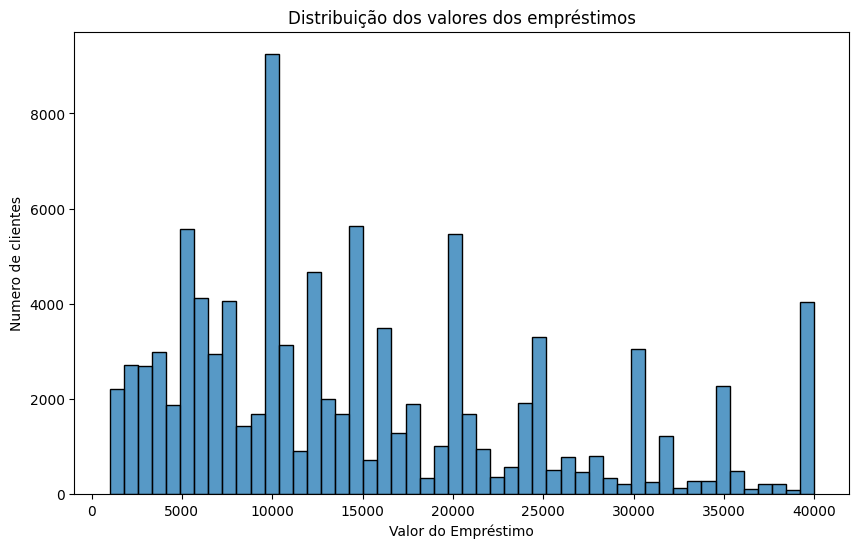

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df["valor"], bins=50, kde=False)
plt.xlabel("Valor do Empréstimo")
plt.ylabel("Numero de clientes")
plt.title("Distribuição dos valores dos empréstimos")

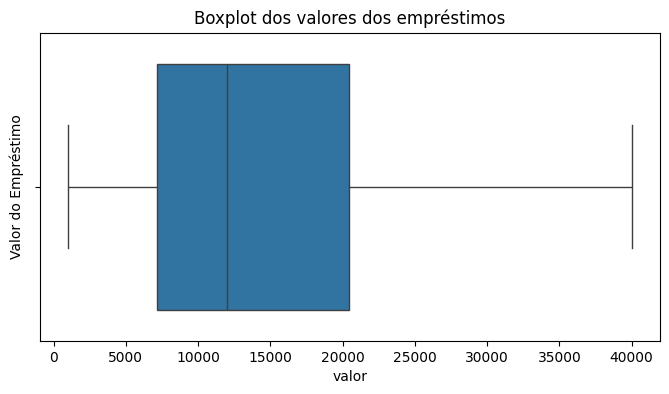

In [26]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["valor"])
plt.ylabel("Valor do Empréstimo")
plt.title("Boxplot dos valores dos empréstimos")
plt.show()

In [27]:
counts, bin_edges = np.histogram(df["valor"], bins=50)

for i in range(len(counts)):
    print(f"{i+1:02d}) Intervalo: {bin_edges[i]:.0f} a {bin_edges[i+1]:.0f} -> {counts[i]} empréstimos")


01) Intervalo: 1000 a 1780 -> 2212 empréstimos
02) Intervalo: 1780 a 2560 -> 2712 empréstimos
03) Intervalo: 2560 a 3340 -> 2696 empréstimos
04) Intervalo: 3340 a 4120 -> 2993 empréstimos
05) Intervalo: 4120 a 4900 -> 1871 empréstimos
06) Intervalo: 4900 a 5680 -> 5564 empréstimos
07) Intervalo: 5680 a 6460 -> 4114 empréstimos
08) Intervalo: 6460 a 7240 -> 2949 empréstimos
09) Intervalo: 7240 a 8020 -> 4053 empréstimos
10) Intervalo: 8020 a 8800 -> 1434 empréstimos
11) Intervalo: 8800 a 9580 -> 1681 empréstimos
12) Intervalo: 9580 a 10360 -> 9244 empréstimos
13) Intervalo: 10360 a 11140 -> 3127 empréstimos
14) Intervalo: 11140 a 11920 -> 915 empréstimos
15) Intervalo: 11920 a 12700 -> 4678 empréstimos
16) Intervalo: 12700 a 13480 -> 2000 empréstimos
17) Intervalo: 13480 a 14260 -> 1681 empréstimos
18) Intervalo: 14260 a 15040 -> 5639 empréstimos
19) Intervalo: 15040 a 15820 -> 721 empréstimos
20) Intervalo: 15820 a 16600 -> 3497 empréstimos
21) Intervalo: 16600 a 17380 -> 1284 emprésti

#### **Resposta:**
 A média dos valores de empréstimo é de US$ 15.142.
Ao analisar as faixas de valores mais frequentes, identifiquei que o intervalo 9.580–10.360 é o mais comum, seguido por 14.260–15.040, ambos próximos da média.
Outras faixas relevantes são 4.900–5.680 e 19.720–20.500.
Somadas, essas quatro faixas concentram aproximadamente 26,5% de todos os empréstimos concedidos.

No boxplot, não foram identificados outliers importantes, o que indica baixa variabilidade e homogeneidade na distribuição dos valores — ou seja, a maior parte dos clientes solicita empréstimos dentro de um padrão relativamente consistente.

Além disso, o valor máximo de empréstimo encontrado foi de US$ 40.000, o que se alinha ao perfil típico de clientes de renda intermediária que recorrem a crédito pessoal de médio porte.

### **Qual a situacao atual dos empréstimos?**

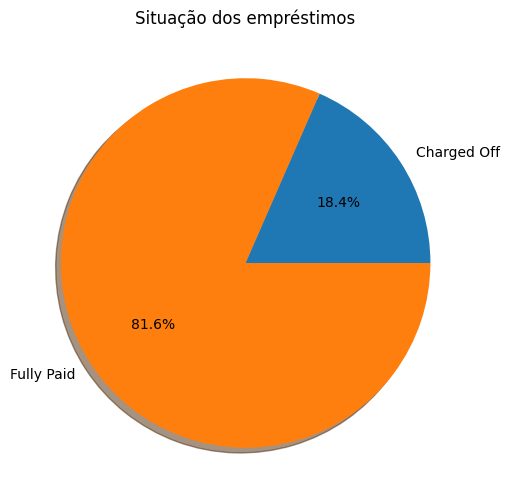

In [28]:

status_grupo=df.groupby("status")["status"].count()

plt.figure(figsize=(6, 6))
plt.pie(status_grupo ,autopct='%1.1f%%',shadow=True, labels=status_grupo.index)
plt.title("Situação dos empréstimos")
plt.show()

####**Resposta:**
Ao analisar o gráfico de pizza com a situação dos empréstimos, identifiquei um cenário desafiador: 81,6% dos contratos estão classificados como Fully Paid, enquanto 18,4% foram Charged Off, indicando inadimplência/perda.

Essa taxa de inadimplência é muito elevada para padrões de crédito pessoal.
No mercado, índices de charged-off costumam variar entre 4% e 12%, dependendo do tipo de carteira — ou seja, este dataset está bem acima do esperado, o que confirma que estamos lidando com uma carteira significativamente arriscada.

Outro ponto importante é a taxa média de juros anual do dataset, de 13,5%, que é relativamente baixa para empréstimos pessoais de risco elevado. Isso indica que a remuneração não compensa totalmente o risco observado.

No geral, esse conjunto de dados representa uma carteira de alto risco, o que a torna especialmente interessante para treinamento de modelos de previsão de inadimplência, dada a forte separação entre bons e maus pagadores.Porém, é um cenário muito ruim para uma empresa real, já que o risco elevado tende a comprometer a lucratividade.

## **Perfil financeiro e risco de crédito dos clientes**

### **Como é o perfil de crédito dos clientes (Fico score) e qual o impacto na inadiplência?**

In [29]:
df['fico_médio'] = (df['fico_min'] + df['fico_max']) / 2

df['fico_médio'].describe()

,fico_médio
count,98326.000000
mean,711.291312
std,37.000388
min,662.000000
25%,682.000000
50%,702.000000
75%,732.000000
max,847.500000


Text(0.5, 1.0, 'Distribuição do Fico score')

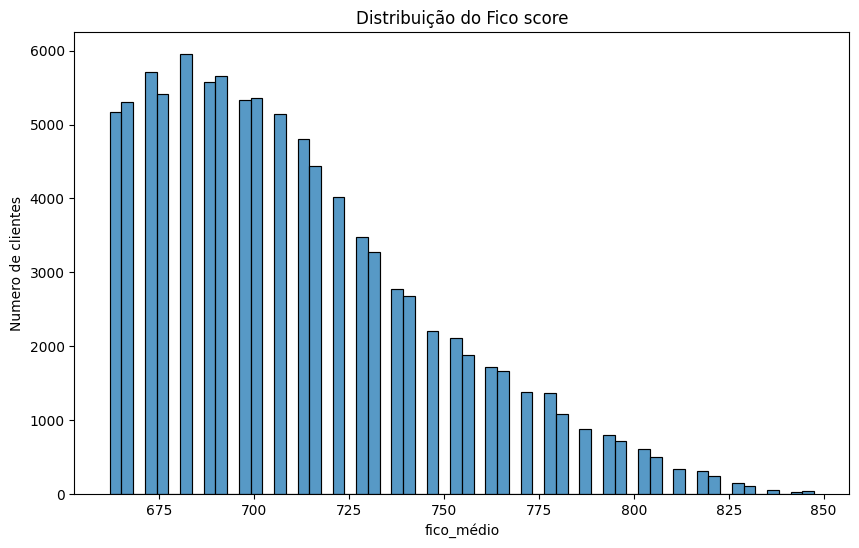

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df["fico_médio"], bins=60, kde=False)
plt.xlabel("fico_médio")
plt.ylabel("Numero de clientes")
plt.title("Distribuição do Fico score")

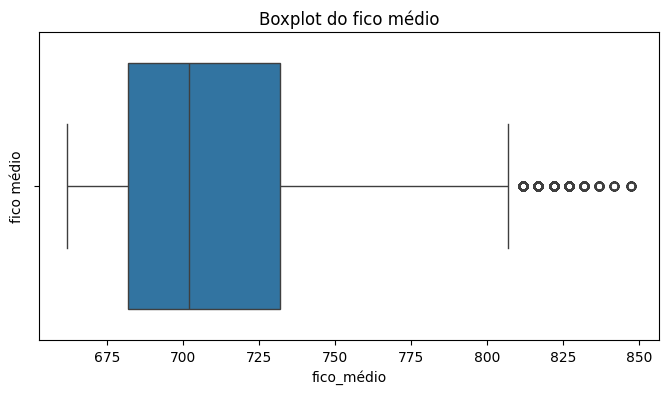

In [31]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["fico_médio"])
plt.ylabel("fico médio")
plt.title("Boxplot do fico médio")
plt.show()

In [32]:
def classificar_fico(score):
    if score < 580:
        return "Ruim"
    elif 580 <= score <= 669:
        return "Razoável"
    elif 670 <= score <= 739:
        return "Bom"
    elif 740 <= score <= 799:
        return "Muito Bom"
    else:
        return "Excelente"

df["fico_categoria"] = df["fico_médio"].apply(classificar_fico)
df.head()

,valor,status,fico_min,fico_max,renda,propósito,contas_abertas,registros_negativos,inadimplências_2anos,juros,estado,data_de_emissão,fico_médio,fico_categoria
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0,0.0756,NV,1/1/2019,777.0,Muito Bom
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0,0.1308,CA,4/1/2019,682.0,Bom
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,2,0.1614,VA,1/1/2019,687.0,Bom
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0,0.1356,NJ,1/1/2019,712.0,Bom
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0,0.0646,OK,1/1/2019,792.0,Muito Bom


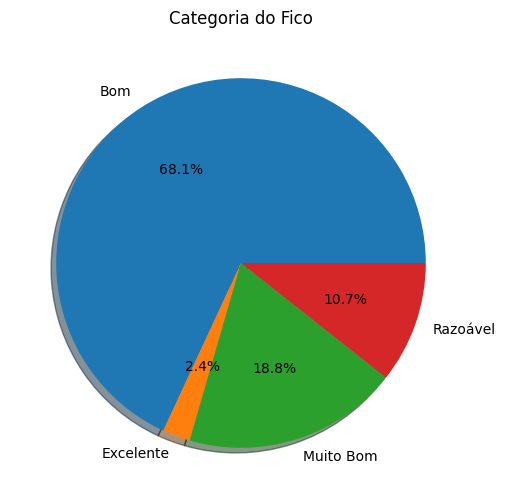

In [33]:
status_grupo=df.groupby("fico_categoria")["fico_categoria"].count()

plt.figure(figsize=(6, 6))
plt.pie(status_grupo ,autopct='%1.1f%%',shadow=True, labels=status_grupo.index)
plt.title("Categoria do Fico")
plt.show()

In [34]:
#avaliando se infuencia ou nao na inadiplencia
df['inadimplência'] = df['status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df.head()

,valor,status,fico_min,fico_max,renda,propósito,contas_abertas,registros_negativos,inadimplências_2anos,juros,estado,data_de_emissão,fico_médio,fico_categoria,inadimplência
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0,0.0756,NV,1/1/2019,777.0,Muito Bom,0
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0,0.1308,CA,4/1/2019,682.0,Bom,1
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,2,0.1614,VA,1/1/2019,687.0,Bom,0
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0,0.1356,NJ,1/1/2019,712.0,Bom,0
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0,0.0646,OK,1/1/2019,792.0,Muito Bom,0


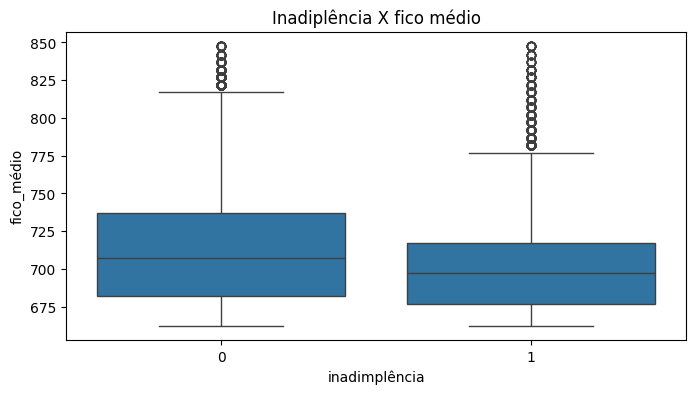

In [35]:
plt.figure(figsize=(8, 4))
sns.boxplot(x = "inadimplência",y="fico_médio", data = df)
plt.title("Inadiplência X fico médio")
plt.show()

In [36]:
taxa = df.groupby('fico_categoria')['inadimplência'].mean()*100
print(taxa)

fico_categoria
Bom          19.674678
Excelente    10.209205
Muito Bom    11.035489
Razoável     25.529884
Name: inadimplência, dtype: float64


####**Respostas:**
 O perfil de crédito dos clientes, analisado pelo FICO Score, mostra uma média de 711,29 pontos, posicionando a maior parte dos clientes na faixa “Bom”.
Apesar da presença de alguns outliers, representando poucos casos de pontuações muito elevadas, a distribuição geral é bastante concentrada.

Ao analisar a proporção de clientes por categoria, observamos:

•Excelente: 2,4%

•Muito Bom: 18,8%

•Bom: 68,8%

•Razoável: 10,7%

Ou seja, quase 87% dos clientes estão entre as categorias Bom e Muito Bom, indicando um perfil de crédito predominantemente sólido, de intermediário a excelente.

---

Impacto do FICO na inadimplência

A análise mostra que o FICO Score influencia diretamente na inadimplência.

1. Boxplot:
O boxplot entre fico_médio e inadimplência mostra que clientes inadimplentes possuem FICO médio visivelmente menor, indicando relação negativa entre FICO e risco.

2. Taxa por categoria:
A taxa de inadimplência apresenta relação inversamente proporcional com o FICO Score — quanto maior o score, menor a chance de inadimplência. Sendo dividido em:

•Razoável: 26%
→ Aproximadamente 1 em cada 4 clientes nessa categoria fica inadimplente.

•Bom: 20%

•Muito Bom: 11%

•Excelente: 10%

Essa queda progressiva reforça que o FICO é um excelente indicador de risco:
à medida que a pontuação aumenta, o risco de inadimplência diminui de forma consistente

### **Os clientes que solicitam empréstimos para diferentes finalidades apresentam diferencas significativas em sua renda anual?**

In [37]:
taxa = df.groupby('propósito')['renda'].agg(['mean','median','count']).sort_values('count',ascending=False)
print(taxa)

                             mean   median  count
propósito                                        
debt_consolidation   86030.670244  70528.0  52955
credit_card          85168.896517  70000.0  22795
home_improvement    100417.272389  80500.0   7167
other                86440.881847  70000.0   6818
major_purchase       90554.853648  75000.0   2289
medical              80193.232972  65000.0   1383
house               101186.681818  75000.0   1144
car                  80742.868664  68000.0   1093
vacation             82289.396750  70000.0    960
small_business      119402.905765  90000.0    902
moving               78977.235079  65690.0    762
renewable_energy     81399.948276  65000.0     58


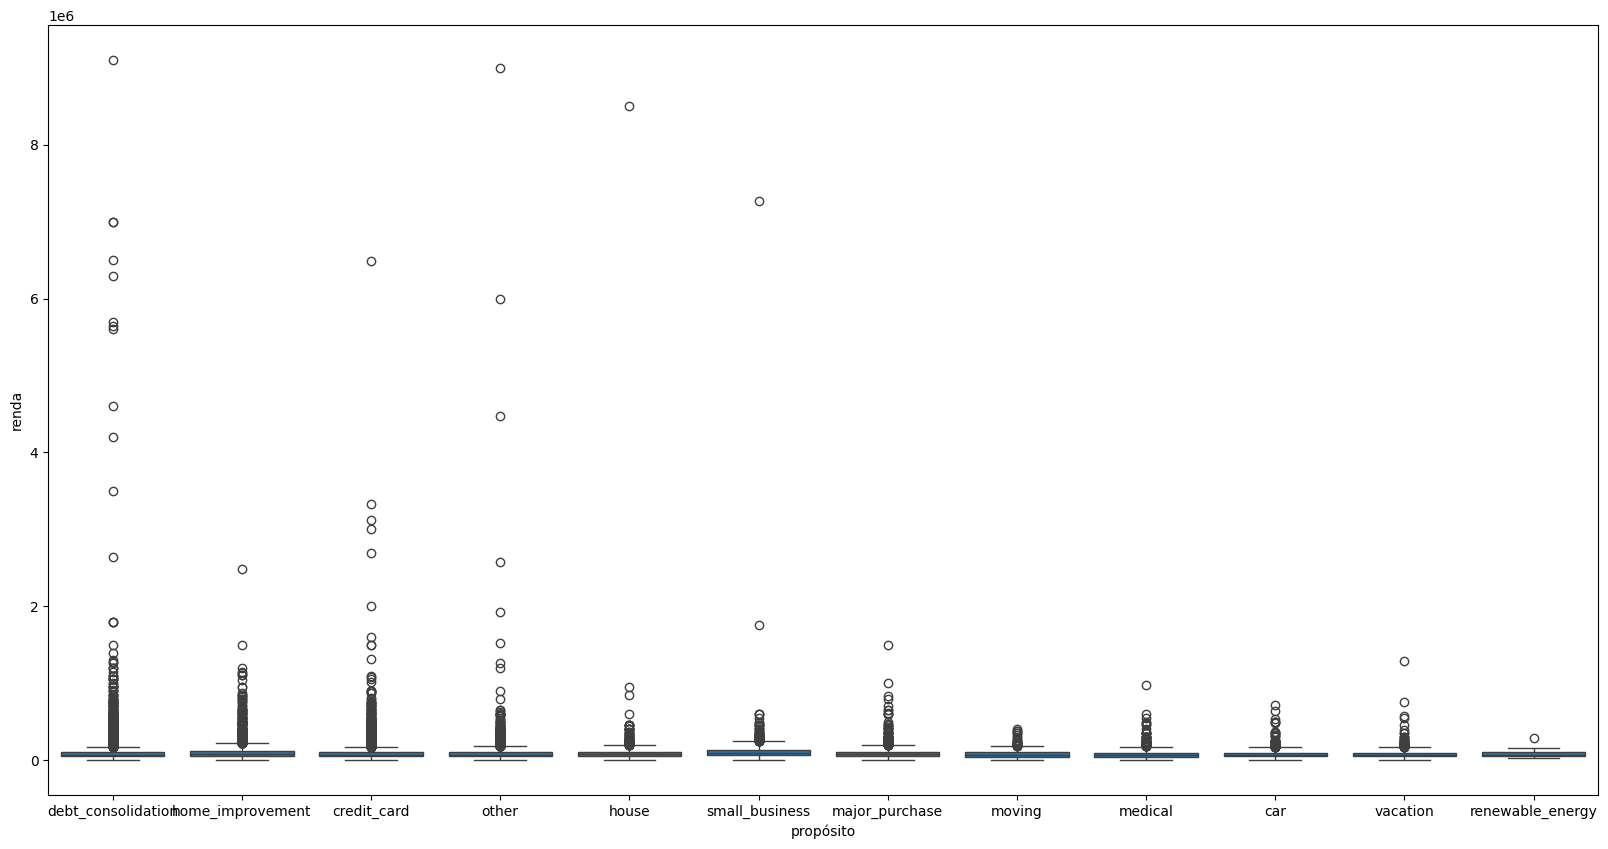

In [38]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='propósito', y= 'renda', data=df)
plt.show()

In [39]:
grupos = [grupo['renda'] for name, grupo in df.groupby('propósito')]
f_oneway(*grupos)

F_onewayResult(statistic=np.float64(21.271885505409482), pvalue=np.float64(7.082288850939676e-44))

#### **Resposta:**
Ao aplicar o teste ANOVA para verificar se existe diferença significativa entre a renda anual dos clientes e o propósito do empréstimo, encontramos:

F-statistic = 21,27 — valor muito acima de 10, indicando uma diferença forte entre as médias dos grupos.

p-value = 7 × 10⁻⁷ — muito menor que 0,05, o que confirma estatisticamente que as rendas diferem de maneira significativa entre os diferentes propósitos de empréstimo.


Ou seja, a variável “propósito” explica parte relevante da variação da renda, comprovando que os clientes que pedem empréstimos por motivos distintos tendem, de fato, a possuir níveis de renda diferentes.

Como análise complementar, observei as médias e agrupei os propósitos em faixas de renda:

**Alta renda (acima de 100k):**

•small_business

•house

•home_improvement

Esses propósitos representam investimentos maiores ou melhorias de patrimônio, condizentes com perfis de maior renda.


**Média renda (85k a 95k):**

•major_purchase

•other

•debt_consolidation

•credit_card

Aqui aparecem finalidades voltadas para consumo relevante ou reorganização financeira.


**Baixa renda (abaixo de 83k):**

•vacation

•renewable_energy

•car

•medical

•moving

São finalidades geralmente ligadas a necessidades mais básicas ou situações pontuais.

Essa segmentação reforça visualmente e conceitualmente o que o teste ANOVA já demonstrou: clientes com diferentes finalidades de empréstimo apresentam perfis de renda distintos, o que confirma a diferença significativa entre os grupos

### **Quais propósitos de empréstimos são mais frequentes e quais apresentam maior risco de indimplência?**

Text(0.5, 1.0, 'Distribuição do propósito')

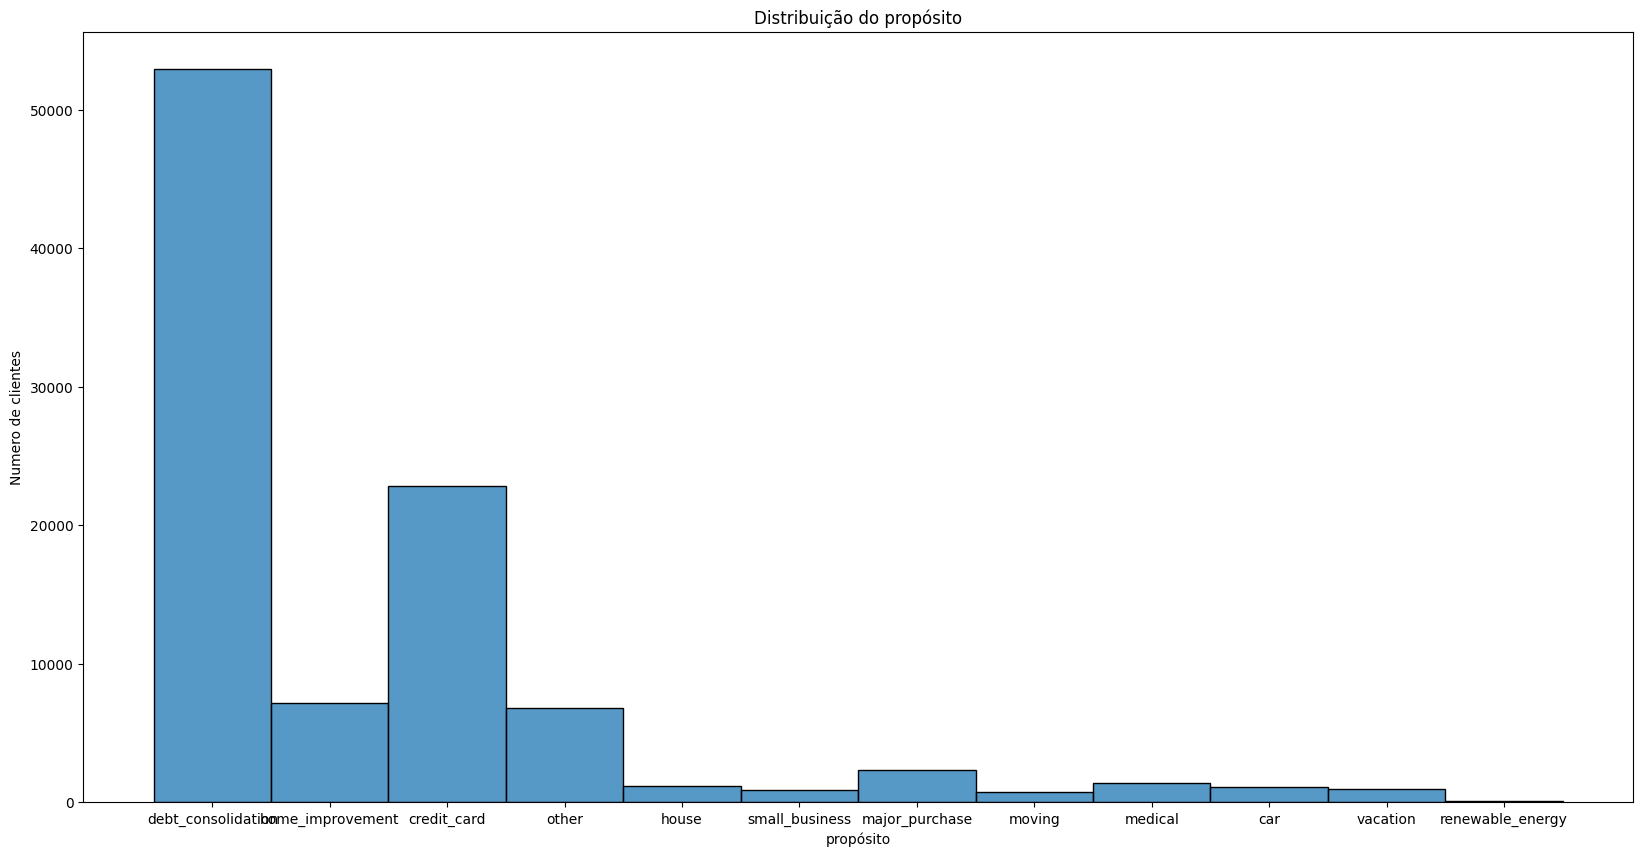

In [40]:
plt.figure(figsize=(20, 10))
sns.histplot(df["propósito"], bins=11, kde=False)
plt.ylabel("Numero de clientes")
plt.title("Distribuição do propósito")


In [41]:
taxa = df.groupby('propósito')['inadimplência'].mean().sort_values(ascending=False)*100
print(taxa)

propósito
small_business        25.277162
debt_consolidation    19.767727
medical               18.510484
credit_card           17.964466
moving                17.716535
renewable_energy      17.241379
house                 15.821678
major_purchase        15.640017
other                 15.635084
home_improvement      15.138831
vacation              13.229167
car                   11.344922
Name: inadimplência, dtype: float64


####**Respostas:**
Os quatro propósitos de empréstimo mais frequentes são debt consolidation, credit card, house improvement e other. O debt consolidation representa 53,8% do total, enquanto credit card corresponde a 23,1%. Juntos, eles representam cerca de 8 em cada 10 empréstimos.

Apesar de ser o motivo mais comum, o debt consolidation aparece apenas como o segundo na taxa de inadimplência, com aproximadamente 20%. O topo do risco fica com small business, que possui cerca de 25% de inadimplência, embora represente apenas 0,9% do total de empréstimos – mostrando que é um propósito muito arriscado.

Entre os top 4 em taxa de inadimplência, o medical aparece com 18,5% de inadimplência (top 3 em risco), enquanto credit card, moving e renewable energy apresentam taxas próximas de 17%, indicando um empate aparente no top 4

## **Fatores de risco e padrões de comportamento**

### **Existe relacão entre o histórico de crédito dos clientes e a probabilidade de atraso de pagmento?**

In [42]:
print(df[['contas_abertas', 'registros_negativos', 'inadimplências_2anos']].describe())
print(df['inadimplência'].value_counts())


       contas_abertas  registros_negativos  inadimplências_2anos
count    98326.000000         98326.000000          98326.000000
mean        11.736570             0.126172              0.231902
std          5.987142             0.338746              0.771209
min          0.000000             0.000000              0.000000
25%          8.000000             0.000000              0.000000
50%         11.000000             0.000000              0.000000
75%         15.000000             0.000000              0.000000
max         84.000000             6.000000             21.000000
inadimplência
0    80193
1    18133
Name: count, dtype: int64


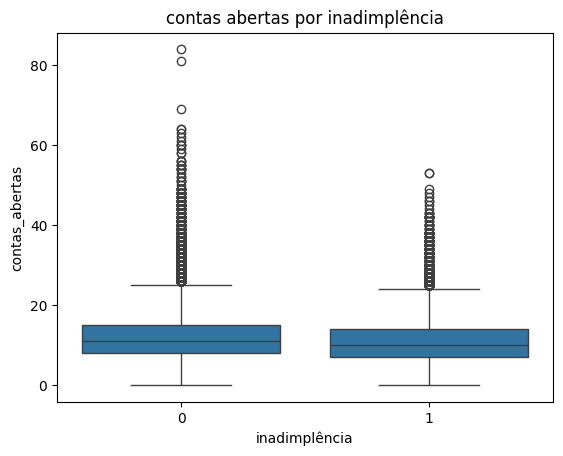

In [43]:
sns.boxplot(y=df["contas_abertas"], x=df["inadimplência"],data=df)
plt.title('contas abertas por inadimplência')
plt.show()

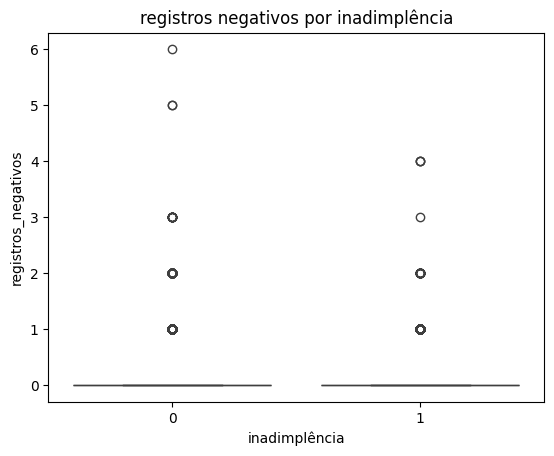

In [44]:
sns.boxplot(y=df["registros_negativos"], x=df["inadimplência"],data=df)
plt.title('registros negativos por inadimplência')
plt.show()

In [45]:
corr1, p1 = spearmanr(df['contas_abertas'], df['inadimplências_2anos'])
corr2, p2 = spearmanr(df['registros_negativos'], df['inadimplências_2anos'])
corr3, p3 = spearmanr(df['contas_abertas'], df['inadimplência'])
corr4, p4 = spearmanr(df['registros_negativos'], df['inadimplência'])

print(f"Contas x Inadimplência 2 anos: corr={corr1:.3f}, p={p1:.3g}")
print(f"Registros x Inadimplência 2 anos: corr={corr2:.3f}, p={p2:.3g}")
print(f"Contas x Inadimplência binária: corr={corr3:.3f}, p={p3:.3g}")
print(f"Registros x Inadimplência binária: corr={corr4:.3f}, p={p4:.3g}")

Contas x Inadimplência 2 anos: corr=0.035, p=3.23e-28
Registros x Inadimplência 2 anos: corr=-0.062, p=4.81e-84
Contas x Inadimplência binária: corr=-0.016, p=5.21e-07
Registros x Inadimplência binária: corr=0.003, p=0.354


In [46]:
grupo_inad = df[df['inadimplência'] == 1]
grupo_adimpl = df[df['inadimplência'] == 0]
stat_contas, p_contas = ttest_ind(grupo_inad['contas_abertas'], grupo_adimpl['contas_abertas'], equal_var=False)
stat_reg, p_reg = ttest_ind(grupo_inad['registros_negativos'], grupo_adimpl['registros_negativos'], equal_var=False)

print(f"T-test Contas Abertas: stat={stat_contas:.3f}, p={p_contas:.3g}")
print(f"T-test Registros Negativos: stat={stat_reg:.3f}, p={p_reg:.3g}")


T-test Contas Abertas: stat=-5.171, p=2.34e-07
T-test Registros Negativos: stat=1.014, p=0.311


Optimization terminated successfully.
         Current function value: 0.477883
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          inadimplência   No. Observations:                98326
Model:                          Logit   Df Residuals:                    98323
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:               0.0002988
Time:                        22:36:35   Log-Likelihood:                -46988.
converged:                       True   LL-Null:                       -47002.
Covariance Type:            nonrobust   LLR p-value:                 7.969e-07
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.4060      0.018    -76.643      0.000      -1.442      -1.370
co

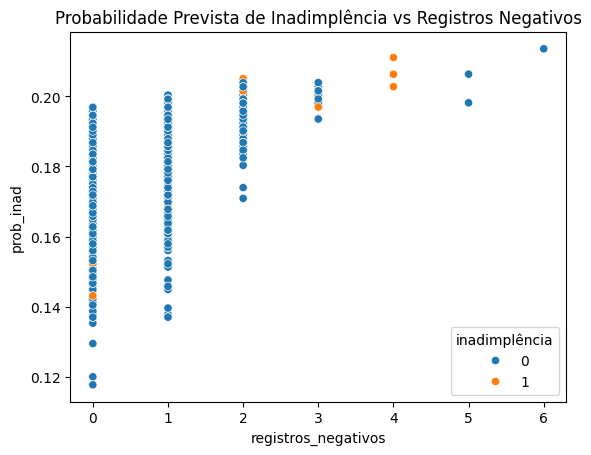

In [47]:
logit_model = smf.logit("inadimplência ~ contas_abertas + registros_negativos", data=df).fit()
print(logit_model.summary())


df['prob_inad'] = logit_model.predict(df[['contas_abertas','registros_negativos']])

sns.scatterplot(x='registros_negativos', y='prob_inad', hue='inadimplência', data=df)
plt.title('Probabilidade Prevista de Inadimplência vs Registros Negativos')
plt.show()

#### **Resposta:**
Para avaliar se o histórico de crédito influencia a inadimplência, separei as variáveis contas abertas e registros negativos, analisando sua relação tanto com a inadimplência dos últimos 2 anos quanto com a inadimplência binária (inadimplente vs. adimplente). A análise foi feita em quatro etapas: exploração visual, correlação, teste de médias e regressão logística.

---

1. Análise exploratória (Boxplots)

Os boxplots iniciais mostraram:

Contas abertas × inadimplência: pequena diferença entre os grupos, sugerindo possível influência.

Registros negativos × inadimplência: praticamente nenhuma diferença visual, indicando baixa relevância inicial.


Esses resultados não foram suficientes para conclusões sólidas, então prossegui com testes estatísticos.

---

2. Correlações (Pearson)

**Inadimplência em 2 anos**

Contas abertas:

•corr = 0.035

•p ≈ 3×10⁻²⁸

→ Relação fraca, porém estatisticamente significativa.

**Registros negativos:**

•corr = −0.062

•p ≈ 4×10⁻⁸⁴

→ Relação fraca e negativa, mas estatisticamente real.

**Inadimplência binária**

Contas abertas:

•corr = −0.016

•p ≈ 5×10⁻⁷

→ Relação extremamente fraca, mas estatisticamente significativa.

**Registros negativos:**

•corr = 0.003

•p = 0.354

→ Sem relação estatística; variável irrelevante para prever inadimplência binária.

---

3. Teste de diferença de médias (T-test)

**Contas abertas:**

•stat = −5.171

•p ≈ 2×10⁻⁷

→ Em média inadimplentes possuem menos contas abertas. Diferença estatisticamente significativa.

**Registros negativos:**

•stat = 1.014

•p = 0.311

→ Sem diferença real entre inadimplentes e adimplentes. Variável não discriminativa.

---

4. Regressão logística (efeito percentual no risco)

Para quantificar o efeito de cada variável no risco de inadimplência:

**Contas abertas** — coef: −0.072
→ Cada nova conta aberta reduz a probabilidade de inadimplência em aproximadamente 7%.

**Registros negativos** — coef: 0.029
→ Cada registro negativo adicional aumenta o risco em cerca de 3%.

---

 **Conclusão final**

O histórico de crédito apresenta influência, porém em níveis diferentes entre as variáveis:

Contas abertas se mostram a variável mais relevante:

aparece com significância na correlação, no teste de médias e na regressão;

sugere que clientes com mais contas abertas possuem menor probabilidade de inadimplência.


Registros negativos apresentam comportamento inconsistente:

não diferenciam inadimplentes no teste de médias;

não têm correlação com a inadimplência binária;

apenas na regressão mostram impacto pequeno (+3%).
→ No geral, têm baixa capacidade preditiva no dataset analisado.



Assim, entre os elementos do histórico de crédito avaliados, contas abertas é a variável que melhor explica a inadimplência, embora o efeito geral ainda seja relativamente fraco.

### **Empréstimos com taxas de juros mais altas estao associados a maiores niveis de inadimplência?**

In [48]:
df['juros'].describe()

,juros
count,98326.000000
mean,0.135689
std,0.053527
min,0.060000
25%,0.088100
50%,0.129800
75%,0.169500
max,0.309900


Text(0.5, 1.0, 'Distribuição dos juros')

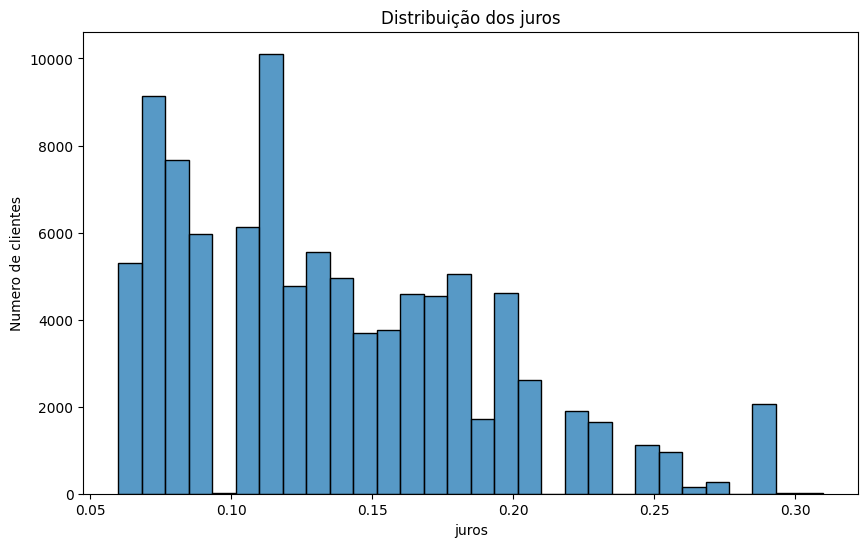

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(df['juros'], bins=30, kde=False)
plt.xlabel("juros")
plt.ylabel("Numero de clientes")
plt.title("Distribuição dos juros")

In [50]:
def classificar_juros(juros):
    if juros < 0.10:
        return "Baixa Taxa"
    elif 0.10 <= juros < 0.15:
        return "Média Taxa"
    elif 0.15 <= juros < 0.20:
        return "Alta Taxa"
    elif  0.20<= juros :
        return "Muito Alta Taxa"

df["juros_categoria"] = df["juros"].apply(classificar_juros)
df.head()

,valor,status,fico_min,fico_max,renda,propósito,contas_abertas,registros_negativos,inadimplências_2anos,juros,estado,data_de_emissão,fico_médio,fico_categoria,inadimplência,prob_inad,juros_categoria
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0,0.0756,NV,1/1/2019,777.0,Muito Bom,0,0.186763,Baixa Taxa
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0,0.1308,CA,4/1/2019,682.0,Bom,1,0.190084,Média Taxa
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,2,0.1614,VA,1/1/2019,687.0,Bom,0,0.188972,Alta Taxa
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0,0.1356,NJ,1/1/2019,712.0,Bom,0,0.186763,Média Taxa
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0,0.0646,OK,1/1/2019,792.0,Muito Bom,0,0.187865,Baixa Taxa


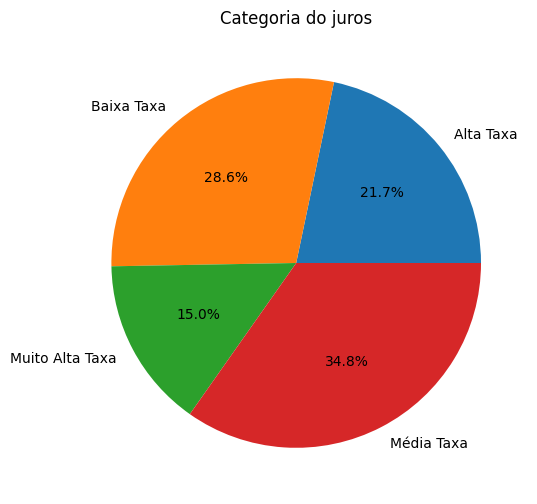

In [51]:
status_grupo=df.groupby("juros_categoria")["juros_categoria"].count()

plt.figure(figsize=(6, 6))
plt.pie(status_grupo ,autopct='%1.1f%%', labels=status_grupo.index)
plt.title("Categoria do juros")
plt.show()

In [52]:
taxa = df.groupby('juros_categoria')['inadimplência'].mean().sort_values(ascending=False)*100
print(taxa)

juros_categoria
Muito Alta Taxa    30.848749
Alta Taxa          25.275085
Média Taxa         17.236234
Baixa Taxa          8.217325
Name: inadimplência, dtype: float64


In [53]:
grupos = [df[df['juros_categoria']==g]['inadimplência'] for g in df['juros_categoria'].unique()]
f_oneway(*grupos)

F_onewayResult(statistic=np.float64(1445.3534133088167), pvalue=np.float64(0.0))

In [54]:
corr, corr_p = spearmanr(df['juros'], df['inadimplência'])
print(f"Correlação de Spearman: {corr:.2f}, p = {corr_p:.4f}")

Correlação de Spearman: 0.21, p = 0.0000


#### **Respostas:**
Ao analisar a taxa de juros, separei os empréstimos em quatro faixas:

•Baixa taxa: <10%

•Média taxa: 10–15%

•Alta taxa: 15–20%

•Muito alta: >20%

Ao visualizar a distribuição em um gráfico de pizza, observei que ela é relativamente homogênea, com a representação de:

•Muito alta: 15%

•Alta: 21,7%

•Média: 34,8%

•Baixa: 28,6%


Esse cenário é considerado ruim devido à grande quantidade de charge-offs (~18%), indicando que o número de empréstimos com juros altos a muito altos deveria ser maior para equilibrar o risco.

---

Analisando a taxa de inadimplência por categoria de juros, encontrei:

•Muito alta: 30,84%

•Alta: 25,27%

•Média: 17,23%

•Baixa: 8,21%

Isso indica uma diferença significativa entre os grupos e evidencia que, quanto maior a taxa de juros, maior a inadimplência.

Para comprovar estatisticamente, realizei:

Teste ANOVA: F-statistic = 1444, p-value ≈ 0, confirmando a diferença significativa entre as categorias.

Correlação Spearman: r = 0,21, mostrando uma relação positiva moderada entre aumento da taxa de juros e aumento da inadimplência.

---

Em síntese, a taxa de juros não apenas segmenta bem os perfis de risco, como também demonstra ser um importante indicador da probabilidade de inadimplência quanto maior a taxa aplicada, maior a inadimplência observada.

### **Como a distribuicao de empréstimo varia entre os estados e quais regiões apresentam maior risco de inadiplência?**

Text(0.5, 1.0, 'Distribuição dos estados')

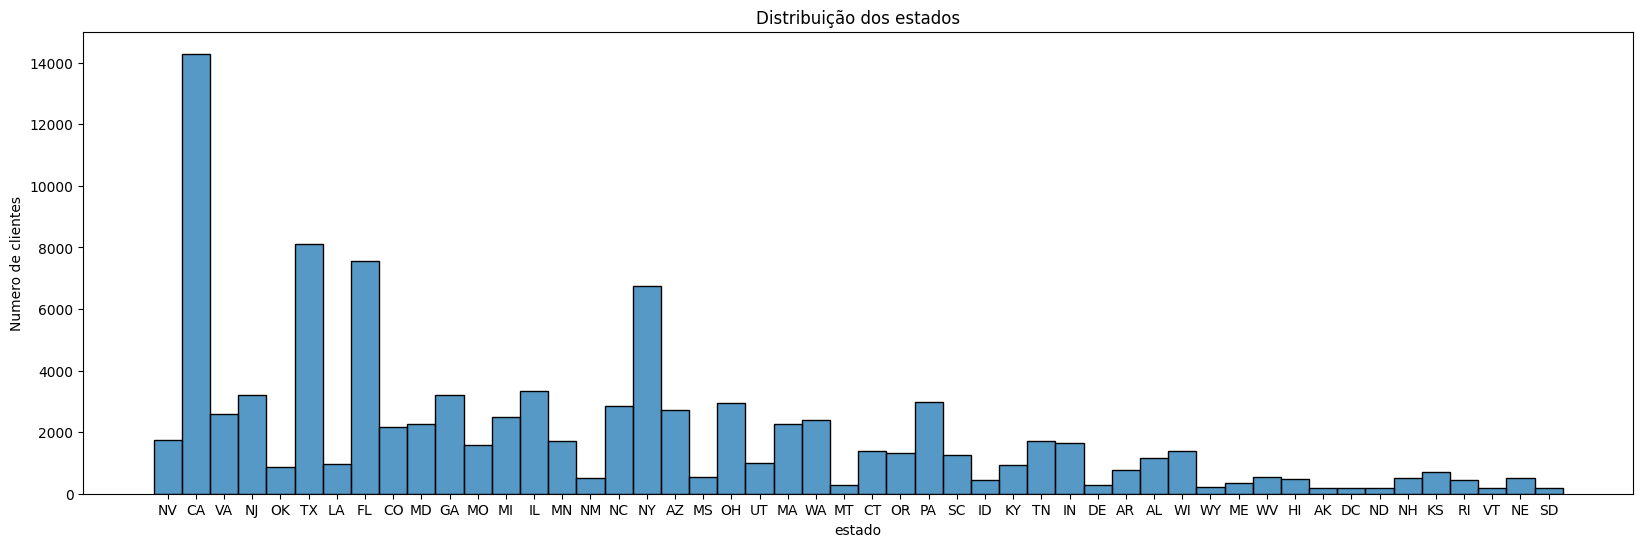

In [55]:
plt.figure(figsize=(20, 6))
sns.histplot(df["estado"], bins=30, kde=False)
plt.ylabel("Numero de clientes")
plt.title("Distribuição dos estados")

In [56]:
df['estado'].value_counts()

,count
estado,
CA,14291
TX,8112
FL,7561
NY,6735
IL,3341
GA,3199
NJ,3194
PA,2984
OH,2950


In [57]:
regioes_eua = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV',
              'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY',
             'AK', 'CA', 'HI', 'OR', 'WA']
}

def mapear_regiao_eua(estado):
    for regiao, estados in regioes_eua.items():
        if estado in estados:
            return regiao
    return 'Unknown'

df['regiao'] = df['estado'].apply(mapear_regiao_eua)

df[['estado', 'regiao']].head()


,estado,regiao
0,NV,West
1,CA,West
2,VA,South
3,NJ,Northeast
4,OK,South


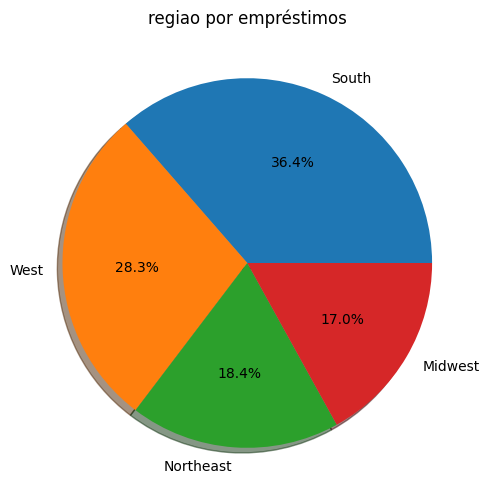

In [58]:
contagem_regiao=df["regiao"].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(contagem_regiao ,autopct='%1.1f%%',shadow=True, labels=contagem_regiao.index)
plt.title("regiao por empréstimos")
plt.show()

In [59]:
taxa = df.groupby('regiao')['inadimplência'].mean().sort_values(ascending=False)*100
print(taxa)

regiao
Northeast    19.449826
South        19.148164
Midwest      17.499250
West         17.441233
Name: inadimplência, dtype: float64


In [60]:
taxa = df.groupby('estado')['inadimplência'].mean().sort_values(ascending=False)*100
print(taxa)

estado
MS    24.637681
AR    23.341837
LA    22.199170
FL    21.835736
CT    21.814255
OK    21.395881
NY    21.365999
NV    21.362587
MD    20.311111
MA    20.131579
IL    19.994014
SD    19.892473
CA    19.753691
TX    19.366371
NM    18.846154
NE    18.762475
AL    18.221071
GA    18.193185
HI    18.142549
IN    17.757576
NJ    17.720726
TN    17.660683
RI    17.567568
KS    17.538897
PA    17.493298
MO    17.358009
NC    17.235315
MN    17.096019
VA    16.537267
NH    16.403162
MI    16.366547
OH    16.237288
AZ    16.105417
WI    16.002896
MT    15.693431
ND    15.675676
DE    14.878893
VT    14.795918
KY    14.574468
SC    14.263074
WA    14.059900
AK    13.861386
UT    13.293051
DC    12.972973
OR    12.396070
CO    11.520737
ID    11.279826
WV    11.153119
WY    10.747664
ME    10.324484
Name: inadimplência, dtype: float64


#### **Respostas:**
Ao analisar a distribuição de empréstimos por estado, observamos uma dispersão relativamente homogênea ao longo do território norte-americano, porém com quatro estados se destacando de forma significativa. Em ordem crescente de volume, os principais são:

**Califórnia** – Líder isolada, impulsionada por sua economia extremamente diversificada: polo global de inovação e tecnologia (Vale do Silício), setor financeiro robusto, forte mercado agrícola e a indústria do entretenimento (Hollywood). Além disso, é o estado mais populoso dos EUA, contribuindo naturalmente para maior demanda por crédito.

**Texas** – Estado que vem se consolidando como novo hub tecnológico, com clima favorável para negócios, custo de vida mais acessível e rápida expansão urbana e industrial.

**Flórida** – Conta com um mercado imobiliário aquecido, grande atividade turística e forte crescimento populacional, fatores que aumentam a oferta e demanda de crédito.

**Nova York** – Principal centro financeiro global, sede de Wall Street e da maior bolsa de valores do mundo, o que torna o mercado de crédito extremamente dinâmico.

Esses quatro estados representam, cada um, o principal polo econômico de suas regiões geográficas — Nova York no Nordeste, Texas e Flórida no Sul e Califórnia no Oeste — demonstrando que a empresa possui presença sólida em três das quatro grandes regiões geográficas dos EUA, o que contribui para uma boa distribuição de operações em todo o território do país.

---

 **Distribuição por região**

Ao agrupar por região, o cenário revela:

•South: 36,4%

•West: 28,3%

•Northeast: 18,4%

•Midwest: 17,0%


O Sul se destaca por concentrar grandes polos populacionais e econômicos, como Texas, Flórida e Geórgia, esta última emergindo como um importante centro cultural e de negócios, atraindo muitos novos moradores.

---

**Risco de inadimplência por região**

Ao avaliar a taxa de inadimplência, não há uma região que se destaque de forma preocupante. As quatro apresentam níveis bastante próximos:

•Northeast: 19,4%

•South: 19,1%

•Midwest: 17,5%

•West: 17,4%


Essa proximidade mostra que o risco é relativamente equilibrado entre as regiões, sem concentração relevante de inadimplência.

No recorte por estado, apenas cerca de 20% se encontram na chamada “zona de atenção”, enquanto a maior parte apresenta níveis mais confortáveis, reforçando a estabilidade geral da carteira

## **Análise temporal e insights estratégicos**

### **Ao longo do tempo, como os empréstimos foram concedidos e houve períodos com aumento significativo na inadiplência?**

In [61]:
df['data_de_emissão'] = pd.to_datetime(df['data_de_emissão'])
df['mês_ano'] = df['data_de_emissão'].dt.to_period('M').astype(str)
df.head()

,valor,status,fico_min,fico_max,renda,propósito,contas_abertas,registros_negativos,inadimplências_2anos,juros,estado,data_de_emissão,fico_médio,fico_categoria,inadimplência,prob_inad,juros_categoria,regiao,mês_ano
0,4200,Fully Paid,775,779,20000.0,debt_consolidation,9,0,0,0.0756,NV,2019-01-01,777.0,Muito Bom,0,0.186763,Baixa Taxa,West,2019-01
1,8000,Charged Off,680,684,28508.0,debt_consolidation,6,0,0,0.1308,CA,2019-04-01,682.0,Bom,1,0.190084,Média Taxa,West,2019-04
2,15350,Fully Paid,685,689,58000.0,debt_consolidation,7,0,2,0.1614,VA,2019-01-01,687.0,Bom,0,0.188972,Alta Taxa,South,2019-01
3,19200,Fully Paid,710,714,131500.0,debt_consolidation,9,0,0,0.1356,NJ,2019-01-01,712.0,Bom,0,0.186763,Média Taxa,Northeast,2019-01
4,20000,Fully Paid,790,794,76000.0,debt_consolidation,8,0,0,0.0646,OK,2019-01-01,792.0,Muito Bom,0,0.187865,Baixa Taxa,South,2019-01


In [62]:
empréstimo_por_mês = df.groupby('mês_ano').size()
empréstimo_por_mês = empréstimo_por_mês.to_frame('empréstimos')
empréstimo_por_mês.head()

,empréstimos
mês_ano,
2019-01,12835
2019-02,9695
2019-03,9140
2019-04,10116
2019-05,9350


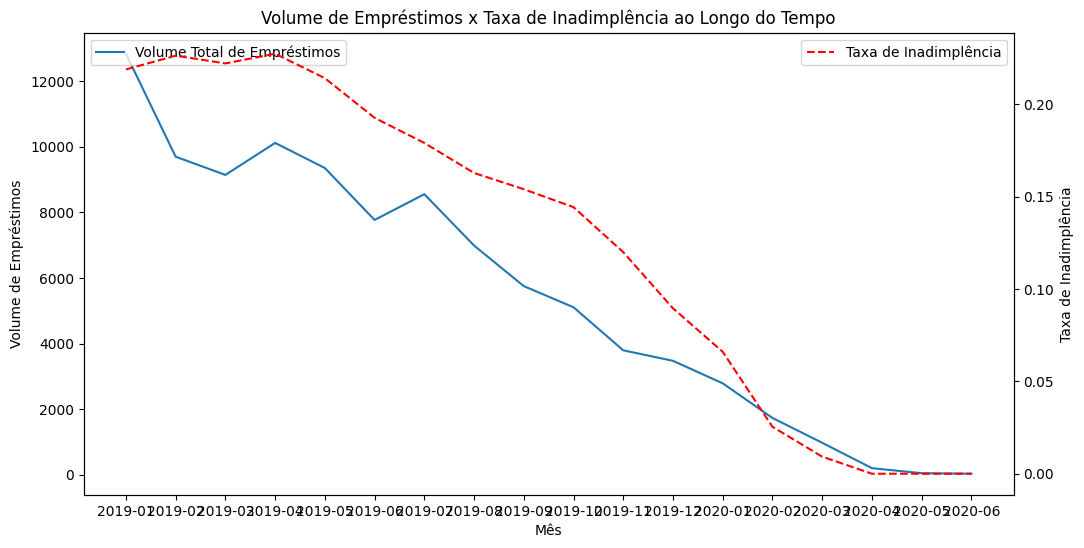

In [63]:
status_por_mes = df.groupby(['mês_ano', 'status']).size().unstack(fill_value=0)
status_por_mes['taxa_inadimplencia'] = (status_por_mes['Charged Off'] / status_por_mes.sum(axis=1))


fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(status_por_mes.sum(axis=1),label='Volume Total de Empréstimos')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Volume de Empréstimos')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(status_por_mes['taxa_inadimplencia'],label='Taxa de Inadimplência',linestyle='--',color='red')
ax2.set_ylabel('Taxa de Inadimplência')
ax2.legend(loc='upper right')

plt.title('Volume de Empréstimos x Taxa de Inadimplência ao Longo do Tempo')
plt.show()

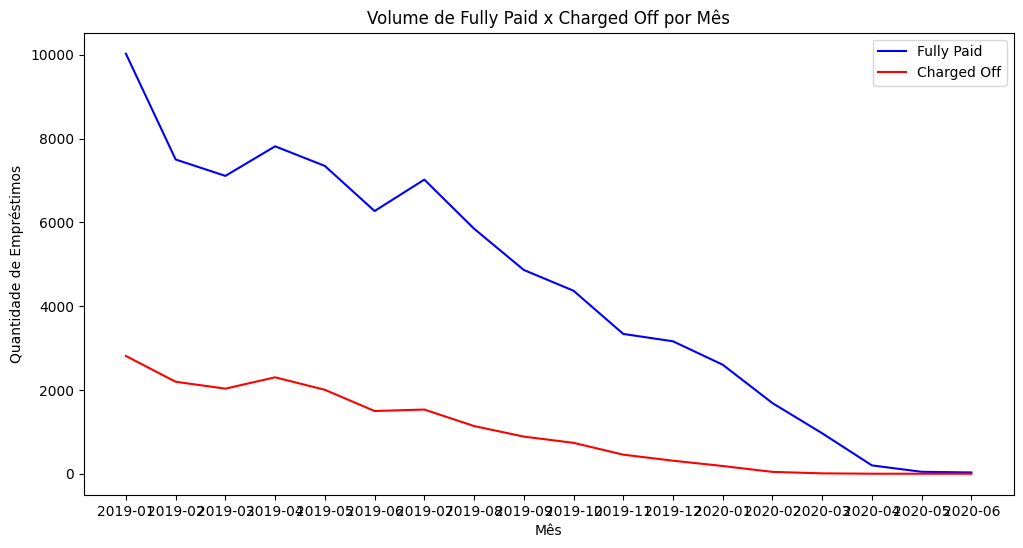

In [64]:
plt.figure(figsize=(12,6))
plt.plot(status_por_mes['Fully Paid'],label='Fully Paid',color='blue')

plt.plot(status_por_mes['Charged Off'],label='Charged Off',color='red')

plt.title('Volume de Fully Paid x Charged Off por Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Empréstimos')
plt.legend()
plt.show()


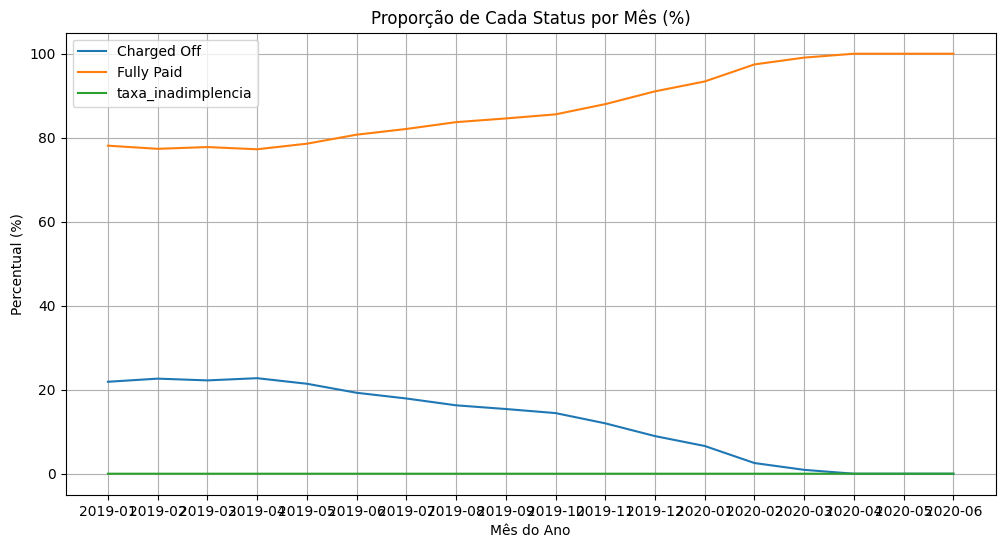

In [65]:
status_por_mes_pct = status_por_mes.div(status_por_mes.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,6))
for col in status_por_mes_pct.columns:
    plt.plot(status_por_mes_pct.index, status_por_mes_pct[col], label=col)

plt.title("Proporção de Cada Status por Mês (%)")
plt.xlabel("Mês do Ano")
plt.ylabel("Percentual (%)")
plt.legend()
plt.grid(True)
plt.show()


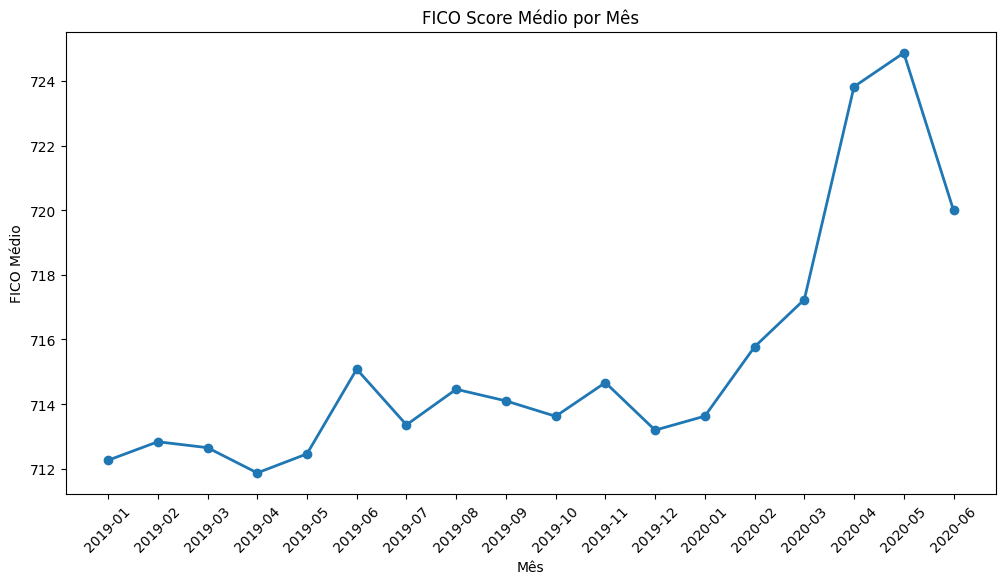

In [66]:
df['data_de_emissão'] = pd.to_datetime(df['data_de_emissão'])
df['month'] = df['data_de_emissão'].dt.month

fico_by_month = df.groupby('mês_ano')['fico_max'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(fico_by_month['mês_ano'], fico_by_month['fico_max'], marker='o', linewidth=2)
plt.title('FICO Score Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('FICO Médio')
plt.xticks(rotation=45)
plt.show()

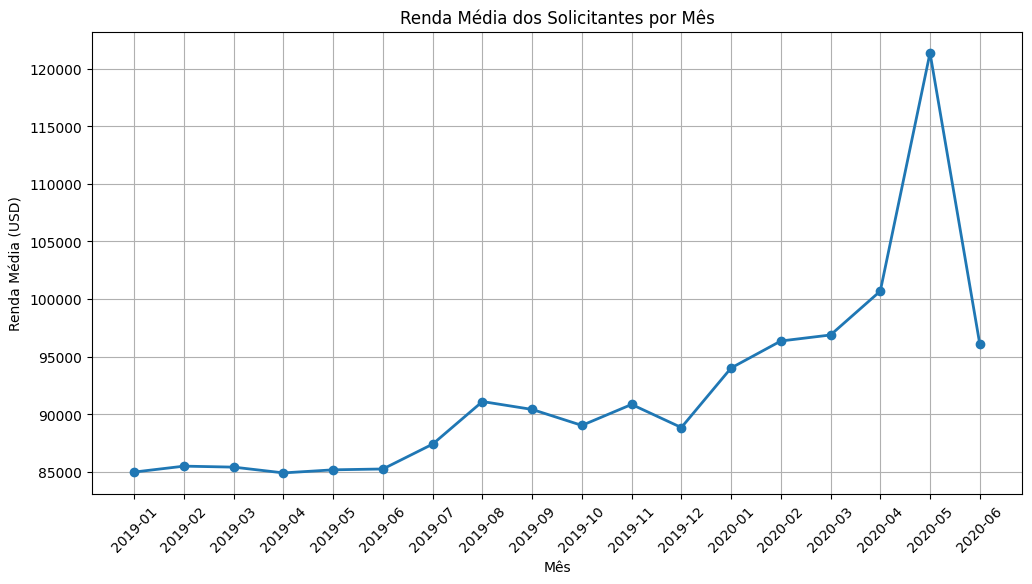

In [67]:
income_by_month = df.groupby('mês_ano')['renda'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(income_by_month['mês_ano'], income_by_month['renda'], marker='o', linewidth=2)
plt.title('Renda Média dos Solicitantes por Mês')
plt.xlabel('Mês')
plt.ylabel('Renda Média (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

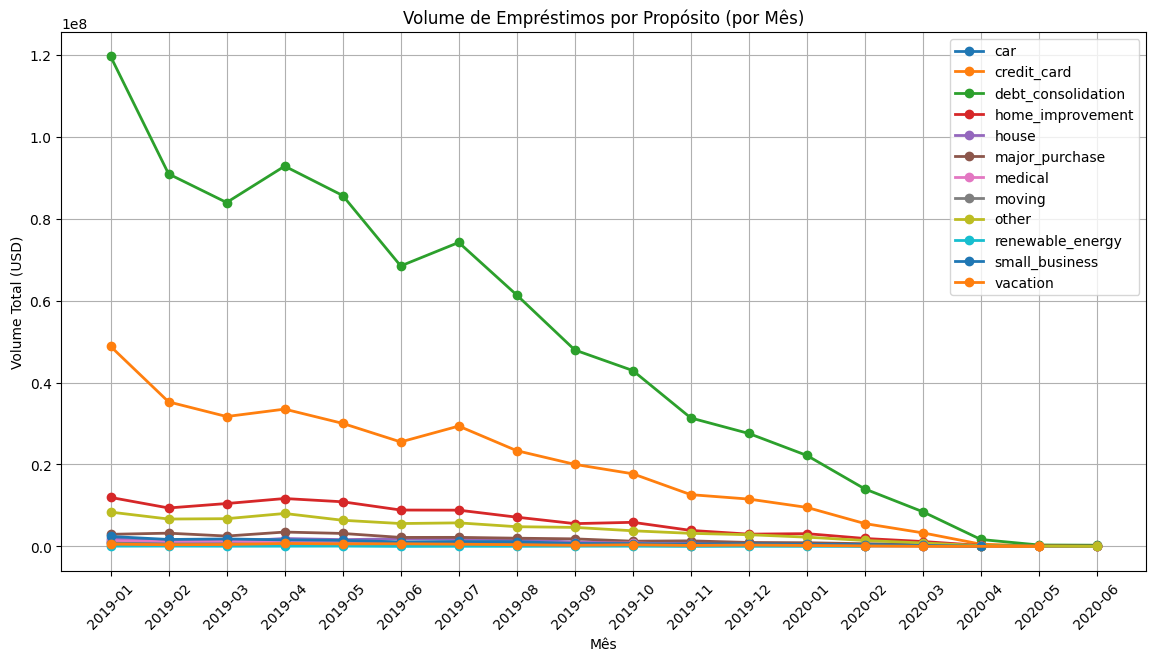

In [68]:
volume_purpose = df.groupby(['mês_ano', 'propósito'])['valor'].sum().reset_index()

plt.figure(figsize=(14,7))
for purpose in volume_purpose['propósito'].unique():
    subset = volume_purpose[volume_purpose['propósito'] == purpose]
    plt.plot(subset['mês_ano'], subset['valor'], marker='o', linewidth=2, label=purpose)

plt.title('Volume de Empréstimos por Propósito (por Mês)')
plt.xlabel('Mês')
plt.ylabel('Volume Total (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

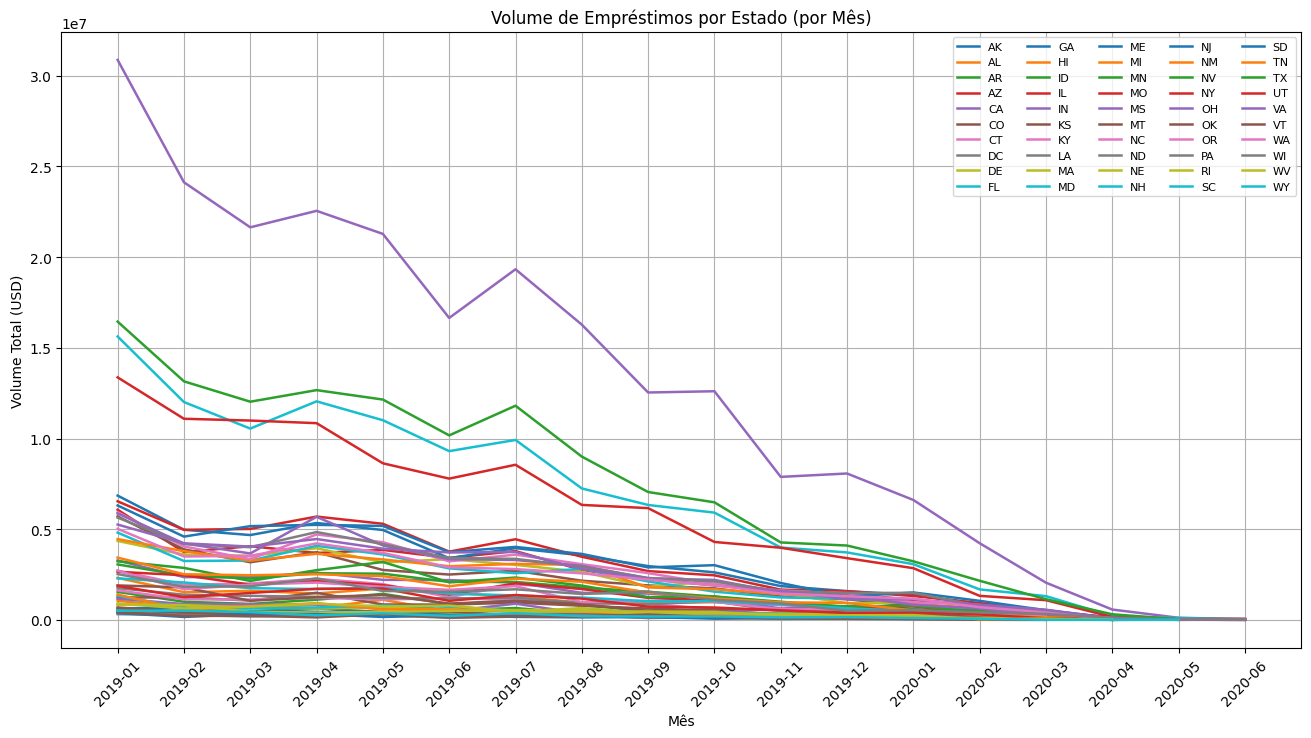

In [69]:
volume_state = df.groupby(['mês_ano', 'estado'])['valor'].sum().reset_index()

plt.figure(figsize=(16,8))

# mesma lógica: uma linha para cada estado
for state in volume_state['estado'].unique():
    subset = volume_state[volume_state['estado'] == state]
    plt.plot(subset['mês_ano'], subset['valor'], linewidth=1.8, label=state)

plt.title('Volume de Empréstimos por Estado (por Mês)')
plt.xlabel('Mês')
plt.ylabel('Volume Total (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(ncol=5, fontsize=8)
plt.show()

#### **Respostas:**
Ao analisar a evolução temporal do volume de empréstimos, observou-se uma queda gradual e contínua ao longo do período analisado (2019–2020), com apenas dois picos intermediários que permaneceram significativamente abaixo do nível inicial. Para identificar os fatores potencialmente responsáveis por essa redução, foram conduzidas análises adicionais envolvendo variáveis críticas do processo de crédito.

1. FICO Médio

A primeira hipótese avaliada foi a de que a queda poderia estar associada ao risco dos solicitantes. Caso o FICO médio estivesse diminuindo, seria esperado um aumento nas rejeições. Entretanto, os resultados mostraram o oposto: o FICO médio aumentou de forma consistente, ultrapassando 724 em determinados meses. Assim, o risco de crédito dos aplicantes não explica a redução do volume.

2. Renda Média

A segunda hipótese considerava a possibilidade de queda na renda média dos requerentes, o que também poderia desencadear um aumento nas reprovações. Contudo, observou-se que a renda apresentou tendência de crescimento ao longo do período, descartando novamente a redução de capacidade financeira dos clientes como causa do fenômeno.

3. Propósito dos Empréstimos

A análise seguinte avaliou o comportamento dos principais propósitos de uso do crédito. Caso apenas alguns deles apresentassem queda significativa, isso poderia indicar mudanças de política, reprecificação ou alterações específicas de demanda. No entanto, todos os propósitos apresentaram redução de volume de forma simultânea, indicando que o problema não era setorial, mas generalizado.

4. Distribuição por Estado

Para verificar se a queda estava concentrada em regiões específicas, avaliou-se o volume por estado. Mais uma vez, os resultados foram claros: todos os estados apresentaram queda consistente na demanda, reforçando a hipótese de um choque externo e não de um comportamento localizado.

5. Contexto Temporal (2019–2020)

Considerando que os dados compreendem os anos de 2019 e 2020, a queda generalizada observada coincide com o período de incerteza econômica provocada pela COVID-19. O final de 2019 já apresentou retração, que se intensificou ao longo de 2020 — período marcado por incertezas, desemprego crescente, menor propensão ao endividamento e ajustes de risco nas instituições financeiras.
Portanto, a explicação mais plausível para a redução significativa no volume é o impacto econômico e comportamental da pandemia.

6. Inadimplência ao Longo do Tempo

Por fim, avaliou-se a taxa de inadimplência, que apresentou redução ao longo do período. Isso ocorreu porque a proporção de empréstimos Fully Paid aumentou gradualmente, enquanto o percentual de Charged Off diminuiu, apresentando uma relação inversa. Esse comportamento sugere que, apesar da queda no volume total concedido, a carteira que permaneceu ativa apresentou melhor desempenho de pagamento, possivelmente refletindo políticas de crédito mais conservadoras durante o período de incerteza.

# **Machine Learning**

## **Quais atributos são mais determinamtes para prever inadimplência?**

In [70]:
dfe['fico_médio'] = (dfe['fico_range_low'] + dfe['fico_range_high']) / 2


In [71]:
dfe['inadimplência'] = dfe['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
dfe.head()

,loan_status,loan_amnt,term,int_rate,installment,annual_inc,dti,revol_bal,revol_util,avg_cur_bal,...,mths_since_recent_revol_delinq,home_ownership,verification_status,purpose,application_type,addr_state,SubGrade,EmploymentLength,fico_médio,inadimplência
0,Fully Paid,4200,36,0.0756,130.77,20000.0,27.61,3775,0.103,554.0,...,35.0,OWN,Not Verified,debt_consolidation,Individual,NV,3,0,777.0,0
1,Charged Off,8000,36,0.1308,269.86,28508.0,7.71,10813,0.440,1802.0,...,35.0,RENT,Not Verified,debt_consolidation,Individual,CA,10,0,682.0,1
2,Fully Paid,15350,60,0.1614,374.43,58000.0,28.35,6478,0.320,4563.0,...,13.0,RENT,Verified,debt_consolidation,Individual,VA,14,0,687.0,0
3,Fully Paid,19200,36,0.1356,652.12,131500.0,29.58,13231,0.827,38333.0,...,35.0,MORTGAGE,Source Verified,debt_consolidation,Individual,NJ,11,11,712.0,0
4,Fully Paid,20000,36,0.0646,612.62,76000.0,10.11,11447,0.183,18236.0,...,35.0,OWN,Not Verified,debt_consolidation,Individual,OK,1,11,792.0,0


In [72]:
grupo_numerico = ["fico_médio","loan_amnt","term","int_rate","installment","annual_inc","dti","revol_bal","revol_util","avg_cur_bal","all_util","total_rev_hi_lim","tot_cur_bal","total_bal_il","total_bal_ex_mort","total_bc_limit","total_il_high_credit_limit","fico_range_low","fico_range_high","delinq_2yrs","open_acc","pub_rec","acc_now_delinq","chargeoff_within_12_mths","num_accts_ever_120_pd","num_tl_90g_dpd_24m","percent_bc_gt_75","pct_tl_nvr_dlq","inq_last_6mths","inq_last_12m","acc_open_past_24mths","mths_since_recent_inq", "mths_since_recent_bc","mths_since_recent_revol_delinq"]

grupo_categoria = ["home_ownership","verification_status","purpose","application_type","addr_state","SubGrade","EmploymentLength"]

In [73]:
dfe_encoded = dfe.copy()
le = LabelEncoder()

for col in grupo_categoria:
    dfe_encoded[col] = le.fit_transform(dfe_encoded[col].astype(str))

In [74]:
corr = dfe_encoded[grupo_numerico + ["inadimplência"]].corr()["inadimplência"].sort_values(ascending=False)
print(corr)

inadimplência                     1.000000
int_rate                          0.208163
installment                       0.095339
revol_util                        0.094106
term                              0.085481
percent_bc_gt_75                  0.083857
loan_amnt                         0.083801
all_util                          0.073177
dti                               0.036507
inq_last_6mths                    0.023096
inq_last_12m                      0.017993
chargeoff_within_12_mths          0.008373
num_tl_90g_dpd_24m                0.004714
pub_rec                           0.003261
delinq_2yrs                       0.000575
acc_open_past_24mths              0.000004
num_accts_ever_120_pd            -0.000088
revol_bal                        -0.003903
acc_now_delinq                   -0.004796
mths_since_recent_revol_delinq   -0.005454
pct_tl_nvr_dlq                   -0.009711
open_acc                         -0.016356
mths_since_recent_bc             -0.017998
mths_since_

In [75]:
chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(dfe_encoded[grupo_categoria], dfe_encoded["inadimplência"])
chi_scores = pd.DataFrame({"categorias": grupo_categoria,"Chi-square": chi2_selector.scores_}).sort_values(by="Chi-square", ascending=False)

print(chi_scores)

            categorias   Chi-square
5             SubGrade  9178.524809
6     EmploymentLength   411.625917
0       home_ownership   404.281793
4           addr_state   328.744624
1  verification_status   245.990959
3     application_type    54.311763
2              purpose    48.253356


In [76]:
X = dfe_encoded[grupo_numerico + grupo_categoria]
y = dfe_encoded["inadimplência"]

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

fi = pd.DataFrame({"Feature": X.columns,"Importancia": rf.feature_importances_}).sort_values(by="Importancia", ascending=False)

print("\nImportância das Features (Random Forest):")
print(fi)


Importância das Features (Random Forest):
                           Feature  Importancia
4                      installment     0.045812
6                              dti     0.045235
3                         int_rate     0.044844
9                      avg_cur_bal     0.043291
12                     tot_cur_bal     0.041526
8                       revol_util     0.039411
7                        revol_bal     0.038514
15                  total_bc_limit     0.038400
11                total_rev_hi_lim     0.038130
5                       annual_inc     0.037956
14               total_bal_ex_mort     0.035801
1                        loan_amnt     0.035734
32            mths_since_recent_bc     0.034914
10                        all_util     0.034374
16      total_il_high_credit_limit     0.033245
13                    total_bal_il     0.032900
38                      addr_state     0.029720
39                        SubGrade     0.028545
31           mths_since_recent_inq     0.0275

### **Resposta:**
Para identificar os atributos mais relevantes para prever inadimplência, realizei um processo em três etapas: seleção inicial, análise estatística e avaliação via modelo de Machine Learning.

---

1. Seleção inicial e tratamento dos dados

Comecei analisando o significado das 90 colunas originais, removendo variáveis redundantes ou sem relação direta com risco de crédito.
Após essa filtragem, permaneci com 41 atributos.

Em seguida, tratei os valores nulos, substituindo-os pela mediana, garantindo consistência para as análises posteriores.

---

2. Avaliação dos atributos numéricos – Correlação

Calculei a correlação entre cada variável numérica e a inadimplência. Os atributos com maior correlação foram:

•int_rate: 0.208 (maior associação positiva)

•fico_médio: -0.123 (associação negativa relevante)


Outros atributos apresentaram correlação moderada, mas ainda úteis para o modelo (entre 0.095 e 0.075):

•installment

•revol_util

•term

•percent_bc_gt_75

•loan_amnt

•all_util

•avg_cur_bal

•tot_cur_bal

Mesmo com correlações mais baixas, esses atributos são importantes.

---

3. Avaliação das variáveis categóricas – Teste Qui-Quadrado

Para as variáveis categóricas, apliquei o teste chi-square. Os resultados mostraram destaque para:

•subgrade: 9178 (altamente informativo)

•employment_length: 411

•home_ownership: 404

•addr_state: 328

•verification_status: 245


As variáveis purpose e application_type apresentaram valores menores (abaixo de 60), mas ainda contribuem para o modelo.

---

4. Importância das features – Random Forest

Treinei um modelo de Random Forest utilizando as 41 colunas para avaliar a importância relativa de cada uma. As mais relevantes foram:

•installment

•dti

•int_rate

•avg_cur_bal

•revol_util

•revol_bal

•total_bc_limit

•total_rev_hi_lim

•fico_médio

•term

Os valores de importância ficaram entre 0.044 e 0.038, indicando que, embora nenhuma variável isolada seja dominante, o conjunto delas favorece a capacidade preditiva do modelo.

---

5. Seleção final dos atributos

Combinando os resultados das três etapas (correlação, chi-square e Random Forest), defini os atributos que serão utilizados no modelo final:

Atributos numéricos selecionados (15):
int_rate, installment, dti, avg_cur_bal, revol_util, revol_bal, total_bc_limit, total_rev_hi_lim, fico_médio, loan_amnt, term, annual_inc, percent_bc_gt_75, all_util, tot_cur_bal

Atributos categóricos selecionados (7):
subgrade, employment_length, home_ownership, addr_state, verification_status, purpose, application_type


---

Explicação dos Atributos Selecionados

**Numéricos:**

•int_rate: taxa de juros do empréstimo; juros mais altos geralmente indicam maior risco.

•installment: valor da parcela mensal; influencia diretamente a capacidade de pagamento.

•dti: percentual da renda comprometida com dívidas; quanto maior, maior o risco.

•avg_cur_bal: saldo médio das contas ativas; reflete estabilidade financeira.

•revol_util: percentual de uso do crédito rotativo; indicador clássico de estresse financeiro.

•revol_bal: valor total de dívida rotativa do cliente.

•total_bc_limit: limite total disponível em cartões de crédito; representa capacidade de crédito.

•total_rev_hi_lim: maior limite rotativo já aprovado para o cliente; mostra confiança prévia do sistema financeiro.

•fico_médio: score médio de crédito; quanto maior, menor o risco.

•loan_amnt: valor total do empréstimo solicitado.

•term: prazo do empréstimo (36 ou 60 meses).

•annual_inc: renda anual declarada.

•percent_bc_gt_75: percentual de cartões com utilização acima de 75%; sinaliza uso excessivo do crédito.

•all_util: percentual total de utilização de crédito considerando todas as contas.

•tot_cur_bal: soma dos saldos das contas atuais; indica liquidez e saúde financeira.

**Categóricos:**

•subgrade: subnível de classificação do empréstimo (ex.: B3, C1); muito informativo para risco.

•employment_length: tempo de emprego; indica estabilidade financeira.

•home_ownership: situação de moradia (rent, own, mortgage); relacionada ao patrimônio.

•addr_state: estado do cliente; captura diferenças regionais de risco.

•verification_status: indica se a renda/identidade foi verificada.

•purpose: finalidade do empréstimo; alguns propósitos carregam mais risco.

•application_type: tipo da aplicação (individual ou conjunta).

---

**Conclusão**

A análise mostrou que não existe um único atributo dominante, mas sim um conjunto de fatores financeiros, comportamentais e demográficos que, quando combinados, oferecem boa capacidade preditiva.
A seleção final garante um conjunto de features equilibrado e adequado para modelos como Random Forest, que se beneficiam de múltiplas variáveis com importâncias complementares

## **Algoritimo de previsao de inadimplência**

In [77]:
numericos_features = ["int_rate", "installment", "dti", "revol_util", "revol_bal","avg_cur_bal", "total_bc_limit", "total_rev_hi_lim", "tot_cur_bal","percent_bc_gt_75", "all_util", "fico_médio", "term","annual_inc", "EmploymentLength"]
categoricos_features = ["SubGrade", "home_ownership", "addr_state", "verification_status","application_type", "purpose"]
X = dfe[numericos_features + categoricos_features]
y = dfe["inadimplência"]

In [78]:
numeric_transform = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

categorical_transform = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(transformers=[("num", numeric_transform, numericos_features),("cat", categorical_transform, categoricos_features)])

In [79]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [80]:
model = Pipeline(steps=[("preprocess", preprocess),("rf", RandomForestClassifier(n_estimators=300,max_depth=14,class_weight="balanced",random_state=42))])

model.fit(X_treino, y_treino)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['int_rate', 'installment',
                                                   'dti', 'revol_util',
                                                   'revol_bal', 'avg_cur_bal',
                                                   'total_bc_limit',
                                                   'total_rev_hi_lim',
                                                   'tot_cur_bal',
                                                   'percent_bc_gt_75',
                                                   'all_util', 'fico_médio',
                                                   'term', 'annual_inc',
                                                   'EmploymentLength']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SubGrade', 'home_ownership',
                                                   'addr_state',
                                                   'verification_status',
                                                   'application_type',
                                                   'purpose'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=14,
                                        n_estimators=300, random_state=42))])

In [81]:
y_pred = model.predict(X_teste)
y_proba = model.predict_proba(X_teste)[:, 1]

print("AUC ROC:", roc_auc_score(y_teste, y_proba))
print("\nClassification Report:\n", classification_report(y_teste, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_teste, y_pred))

AUC ROC: 0.7030426919990463

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80     16039
           1       0.31      0.54      0.40      3627

    accuracy                           0.70     19666
   macro avg       0.59      0.64      0.60     19666
weighted avg       0.77      0.70      0.72     19666


Confusion Matrix:
 [[11751  4288]
 [ 1665  1962]]


### **Como realizei:**
1. Pré-processamento dos dados

Separei os atributos em numéricos e categóricos.

Para atributos numéricos, usei SimpleImputer preenchendo valores faltantes com a mediana.

Para atributos categóricos, usei SimpleImputer preenchendo com os valores mais frequentes e apliquei OneHotEncoder.

Com ColumnTransformer, combinei pipelines específicas para cada tipo de atributo em um bloco unificado.

2. Divisão dos dados

Separei X e y em treino e teste, usando test_size=0.2 (80% para treino, 20% para teste).

3. Primeira tentativa: Random Forest sem balanceamento

O modelo apresentou recall da classe inadimplente quase 0, ou seja, quase todos os clientes eram aprovados.

A matriz de confusão mostrou que apenas 2 inadimplentes foram identificados.

**Conclusão:** o modelo não era viável, pois geraria alto risco financeiro.

4. Ajuste do modelo: Random Forest com class_weight='balanced'

Recall da classe inadimplente: 0.54 → mais da metade dos inadimplentes foram identificados.

AUC-ROC: 0.70, considerado bom para área de crédito.

Recall da classe bons pagadores: 0.73, indicando que alguns bons clientes foram classificados como inadimplentes.

Matriz de confusão: de 3.627 inadimplentes, 1.962 foram identificados corretamente, 4.288 bons pagadores foram classificados como inadimplentes.

---
**Conclusão geral:**

O modelo final apresenta equilíbrio entre identificar inadimplentes e aprovar bons clientes, sendo aceitável para reduzir o risco econômico. Apesar de alguns bons pagadores serem classificados erroneamente, conseguimos evitar perdas significativas, o que é o principal objetivo para o banco.